In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def rbf_kernel(X,image_number):
    sigma_s = -0.02
    sigma_c = -0.02
    W = np.zeros((10000,10000))
    for i in range(10000):
        x1 = i//100
        y1 = i%100
        for j in range(i+1,10000):
            x2 = j//100
            y2 = j%100
            if image_number==1:
                w = np.exp(sigma_s*((x1-x2)**2+(y1-y2)**2))*np.exp(sigma_c*(np.linalg.norm(im[x1,y1]-im[x2,y2])**2))
            else:
                w = np.exp(sigma_s*((x1-x2)**2+(y1-y2)**2))*np.exp(sigma_c*(np.linalg.norm(im2[x1,y1]-im2[x2,y2])**2))
            W[i,j] = W[j,i] = w
    return W

In [185]:
def init(U,method,k,image_number):
    means = np.zeros((k,k))
    if method == 0:
        print('Init method: random')
        temp = np.random.randint(10000,size=k)
        for i in range(k):
            means[i] = U[temp[i]]
    else:
        print('Init method: kmeans++')
        temp = np.random.randint(10000)
        means[0] = U[temp]
        for i in range(1,k):
            dist = np.zeros(10000)
            for j in range(10000):
                temp = np.zeros(i)
                for p in range(i):
                    temp[p] = np.linalg.norm(U[j]-means[p])
                dist[j] = np.min(temp)
            dist = dist/dist.sum()
            temp = np.random.choice(10000,1,p=dist)
            means[i,:] = U[temp,:]
    return means

In [201]:
def classify(U,means,k,image_number):
    res = np.zeros(10000)
    for i in range(10000):
        temp = np.zeros(k)
        for j in range(k):
            temp[j] = np.linalg.norm(U[i]-means[j])
        res[i] = np.argmin(temp)
    return res

In [170]:
def update(U,res,k,image_number):
    means = np.zeros((k,k))
    count = np.zeros(k)
    for i in range(10000):
        cluster = int(res[i])
        count[cluster] += 1
        means[cluster] += U[i]
    for i in range(k):
        means[i] /= count[i]
    return means

In [80]:
def draw(res,image_number,iteration,k,method,cut):
    if method == 0:
        method = 'random'
    else:
        method = 'kmeans++'
    plt.title("Spectral, {} means after {} iters, Image {}\ninit method: {}, cut method: {}".format(k,iteration,image_number,method,cut))
    if image_number==1:
        plt.imshow(im.astype('int'))
    else:
        plt.imshow(im2.astype('int'))
    plt.imshow(res.reshape(100,100),alpha = 0.8)
    plt.savefig('Spectral_{}means_image{}_{}_{}_{}iters.png'.format(k,image_number,cut,method,iteration))

In [145]:
def draw_eigenspace(U,res,k,image_number):
    color = ['#bcbd22', '#17becf']
    for i in range(k):
        for j in range(10000):
            if res[j]==i:
                plt.scatter(U[j][0],U[j][1],c=color[i])
    plt.savefig('Spectral Clustering EigenSpace_{}.png'.format(image_number))

In [203]:
def k_means(k,U,image_number,cut_method):
    print("k={}".format(k))
    iteration = np.zeros(2,dtype=np.int)
    for i in range(1,2):
        res_prev = np.random.randint(k,size=10000)
        means= init(U,i,k,image_number)
        while(1):
            iteration[i]+=1
            diff = 0
            res = classify(U,means,k,image_number)
            new_means = update(U,res,k,image_number)
            #draw(res,image_number,iteration[i],k,i,cut_method)
            for j in range(10000):
                if res[j] != res_prev[j]:
                    diff += 1
            print('iteration: {}, diff: {}'.format(iteration[i],diff))
            if diff <10 and iteration[i]!=1:
                break
            res_prev = res
            means = new_means
        if(k==2):
            draw_eigenspace(U,res,k,image_number)

In [9]:
im = imageio.imread('image1.png').astype('float32')
im2 = imageio.imread('image2.png').astype('float32')

In [9]:
W1 = rbf_kernel(im,1)
W2 = rbf_kernel(im2,2)

In [29]:
D1 = np.diag(np.sum(W1,axis=1))
D2 = np.diag(np.sum(W2,axis=1))
L1 = D1-W1
L2 = D2-W2
eigen_values_1, eigen_vectors_1 = np.linalg.eig(L1)
eigen_values_2, eigen_vectors_2 = np.linalg.eig(L2)
eigen_vectors_1_sort = eigen_vectors_1[:,np.argsort(eigen_values_1)]
eigen_vectors_2_sort = eigen_vectors_2[:,np.argsort(eigen_values_2)]

In [55]:
U1 = (eigen_vectors_1_sort[:,:10])
U2 = (eigen_vectors_2_sort[:,:10])

k=2
Init method: kmeans++
iteration: 1, diff: 5075
iteration: 2, diff: 24
iteration: 3, diff: 0
k=2
Init method: kmeans++
iteration: 1, diff: 5060
iteration: 2, diff: 0


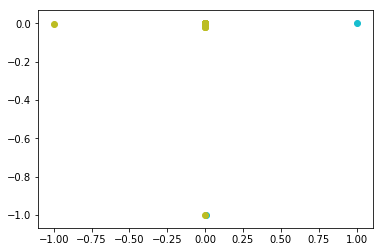

In [207]:
for k in range(2,3):
    U1_input = (U1[:,4:k+4])
    U2_input = (U2[:,6:k+6])
    k_means(k,U1_input,1,'ratio cut')
    k_means(k,U2_input,2,'ratio cut')

In [65]:
np.sort(eigen_values_1)

array([3.66646400e-15, 4.52477205e-15, 4.04122120e-14, ...,
       8.93353264e+01, 9.07205524e+01, 9.10904699e+01])

In [11]:
D1_inv = np.linalg.inv(D1**0.5)
D2_inv = np.linalg.inv(D2**0.5)
L1_sym = np.dot(np.dot(D1_inv,L1),D1_inv)
L2_sym = np.dot(np.dot(D2_inv,L2),D2_inv)
eigen_values_normal_1, eigen_vectors_normal_1 = np.linalg.eig(L1_sym)
eigen_values_normal_2, eigen_vectors_normal_2 = np.linalg.eig(L2_sym)

In [30]:
eigen_vectors_normal_1_sort = eigen_vectors_normal_1[:,np.argsort(eigen_values_normal_1)]
eigen_vectors_normal_2_sort = eigen_vectors_normal_2[:,np.argsort(eigen_values_normal_2)]

In [56]:
U1_normal = (eigen_vectors_normal_1_sort[:,:10])
U2_normal = (eigen_vectors_normal_2_sort[:,:10])

k=2
Init method: random
iteration: 1, diff: 0
iteration: 2, diff: 1724
iteration: 3, diff: 466
iteration: 4, diff: 133
iteration: 5, diff: 42
iteration: 6, diff: 24
iteration: 7, diff: 0
Init method: kmeans++
iteration: 1, diff: 0
iteration: 2, diff: 366
iteration: 3, diff: 77
iteration: 4, diff: 24
iteration: 5, diff: 10
iteration: 6, diff: 0
k=2
Init method: random
iteration: 1, diff: 0
iteration: 2, diff: 716
iteration: 3, diff: 355
iteration: 4, diff: 176
iteration: 5, diff: 85
iteration: 6, diff: 44
iteration: 7, diff: 27
iteration: 8, diff: 6
Init method: kmeans++
iteration: 1, diff: 0
iteration: 2, diff: 650
iteration: 3, diff: 392
iteration: 4, diff: 234
iteration: 5, diff: 126
iteration: 6, diff: 61
iteration: 7, diff: 38
iteration: 8, diff: 7
k=3
Init method: random
iteration: 1, diff: 1
iteration: 2, diff: 2959
iteration: 3, diff: 1504
iteration: 4, diff: 1141
iteration: 5, diff: 678
iteration: 6, diff: 397
iteration: 7, diff: 203
iteration: 8, diff: 82
iteration: 9, diff: 3

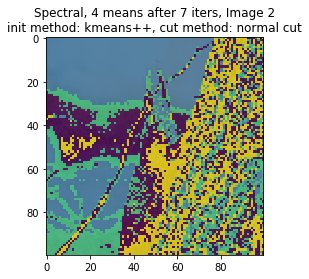

In [82]:
for k in range(2,5):
    U1_normal = (U1_normal[:,:k+1])[:,4:]
    U2_normal = (U2_normal[:,:k+1])[:,4:]
    k_means(k,U1_normal,1,'normal cut')
    k_means(k,U2_normal,2,'normal cut')

In [57]:
np.savetxt("U1.csv", U1, delimiter=",")
np.savetxt("U2.csv", U2, delimiter=",")
np.savetxt("U1n.csv", U1_normal, delimiter=",")
np.savetxt("U2n.csv", U2_normal, delimiter=",")

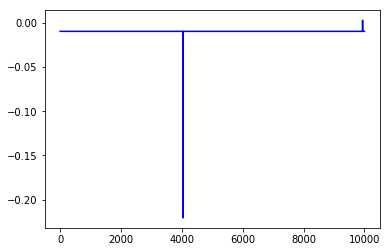

In [28]:
plt.plot(U1[:10000,1],'b')

In [10]:
import pandas as pd

In [144]:
U1=np.array(pd.read_csv('U1.csv',header=None))
U2=np.array(pd.read_csv('U2.csv',header=None))
U1_normal=np.array(pd.read_csv('U1n.csv',header=None))
U2_normal=np.array(pd.read_csv('U2n.csv',header=None))

In [94]:
U1 = (U1[:,:3])[:,1:]
U2 = (U2[:,:3])[:,1:]
U1_normal = (U1_normal[:,:3])[:,1:]
U2_normal = (U2_normal[:,:3])[:,1:]

In [143]:
U1.shape

(10000, 10)

In [163]:
xx = np.zeros((2,2))
xx

array([[0., 0.],
       [0., 0.]])

In [169]:
xx[0] = a[1]
xx

array([[2., 2.],
       [0., 0.]])

In [195]:
a = [[3,3],[2,2]]

In [196]:
xx

array([[2., 2.],
       [0., 0.]])

In [198]:
xx[0] / a[0]

array([0.66666667, 0.66666667])